# Improved feedback

Luís F. Simões

*2019-02-28*

This notebook provides a walkthrough of the latest additions to the "`embiggen`" module:
* faster scoring;
* plotting image comparisons.

----

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

----

Watermark of the environment in which this notebook was executed.

In [1]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,matplotlib,seaborn,scipy,skimage,PIL,numba
# https://github.com/rasbt/watermark

CPython 3.5.3
IPython 6.4.0

numpy 1.14.5
pandas 0.23.3
matplotlib 2.2.2
seaborn 0.9.0
scipy 1.1.0
skimage 0.14.2
PIL 5.4.1
numba 0.42.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit


----

# Imports

In [2]:
from embiggen import *

In [3]:
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

In [4]:
#DATA_PATH = 'probav_data/'
DATA_PATH = 'C:/Kaggle/proba/'

assert os.path.exists(DATA_PATH), 'Dataset not found'

In [5]:
train_set = all_scenes_paths(DATA_PATH + 'train/')
test_set  = all_scenes_paths(DATA_PATH + 'test/')

----

# Faster scoring with numba

A new function **`score_image_fast()`** was added to the module. It calls another new function, **`score_against_hr()`**, that has its code parallelized and compiled by Numba.

In case you don't know it, Numba is a "JIT compiler that translates a subset of Python and NumPy code into fast machine code". You can learn more about it at https://numba.pydata.org/.

Even though the scoring now relies on compiled code, there's no additional overhead to use the module. Just "`pip install numba`" and you're done.

The function `score_images()` and class `scorer` were both changed to call `score_image_fast()` instead of `score_image()`. If you were using them to score your images, there is then no need to change anything in your code to benefit from the speed improvement.

Below we score the baseline approach with the old and new functions:

In [6]:
srs = [
    baseline_upscale(scene)
    for scene in tqdm(train_set)]

|##########| 1160/1160 100% [elapsed: 02:23 left: 00:00,  8.06 iters/sec]


In [7]:
%time scores_old = [score_image(i, s)      for i,s in zip(srs, train_set)]
%time scores_new = [score_image_fast(i, s) for i,s in zip(srs, train_set)]

Wall time: 2min 18s
Wall time: 1min 7s


The time to score the whole train set is cut in half:

In [8]:
pd.Timedelta('1min 7s') / pd.Timedelta('2min 18s')

0.4855072463768116

Both functions return the exact same scores, except for floating point precision issues:

In [9]:
assert np.mean(scores_old) == np.mean(scores_new) == 1.0
assert np.allclose(scores_old, scores_new)

diff = np.array(scores_old) - scores_new
np.max(np.abs(diff))

2.90878432451791e-14

Below we use class `scorer` to score the "median of all" setup shown in the previous notebook ([here](https://nbviewer.jupyter.org/github/lfsimoes/probav/blob/master/00%20-%20module%20demo.ipynb#Beating-the-baseline)). We obtain the exact same score (`0.998985016169725`), but computing it took roughly 1 minute, whereas before it took 2 and a half minutes.

In [10]:
score = scorer(train_set)

Preloading hi-res images: |##########| 1160/1160 100% [elapsed: 00:06 left: 00:00, 176.50 iters/sec]


In [11]:
sr = [
    central_tendency(scene_path, agg_with='median', only_clear=False)
    for scene_path in tqdm(score.paths, desc='aggregation')]

sr = [
    bicubic_upscaling(img)
    for img in tqdm(sr, desc='upscaling  ')]

sc, sc_imgs = score(sr, per_image=True, desc='scoring    '); sc

aggregation: |##########| 1160/1160 100% [elapsed: 00:47 left: 00:00, 24.60 iters/sec]
upscaling  : |##########| 1160/1160 100% [elapsed: 00:23 left: 00:00, 49.84 iters/sec]
scoring    : |#########-| 1155/1160  99% [elapsed: 01:02 left: 00:00, 18.52 iters/sec]

0.998985016169725

----

# Visual inspections

Three new functions were added to `embiggen/inspect.py`:
* **`create_panel()`**,
* **`compare_images()`**,
* **`compare_to_hr()`**.

The sections below demonstrate how to use each of them.

## `create_panel()`

This function initializes a matplotlib figure and the corresponding axes with settings convenient for the proper display of the satellite images: no ticks, no frame, equal aspect, tigh layout and automatic sizing.

Call by specifying the desired number of columns and rows:

    >>> fig, axs = create_panel(ncols, nrows)

`axs` will be a list of `matplotlib.axes` if `nrows=1`, or a list of lists if `nrows>1`. To iterate sequentially over them, in both cases, you can use `axs.flat`.

Below we use `create_panel()` to display all of a scene's low-resolution images.

In [12]:
scene = DATA_PATH + 'train/RED/imgset0102'

lrsm = list(lowres_image_iterator(scene))
lr, sm = zip(*lrsm)

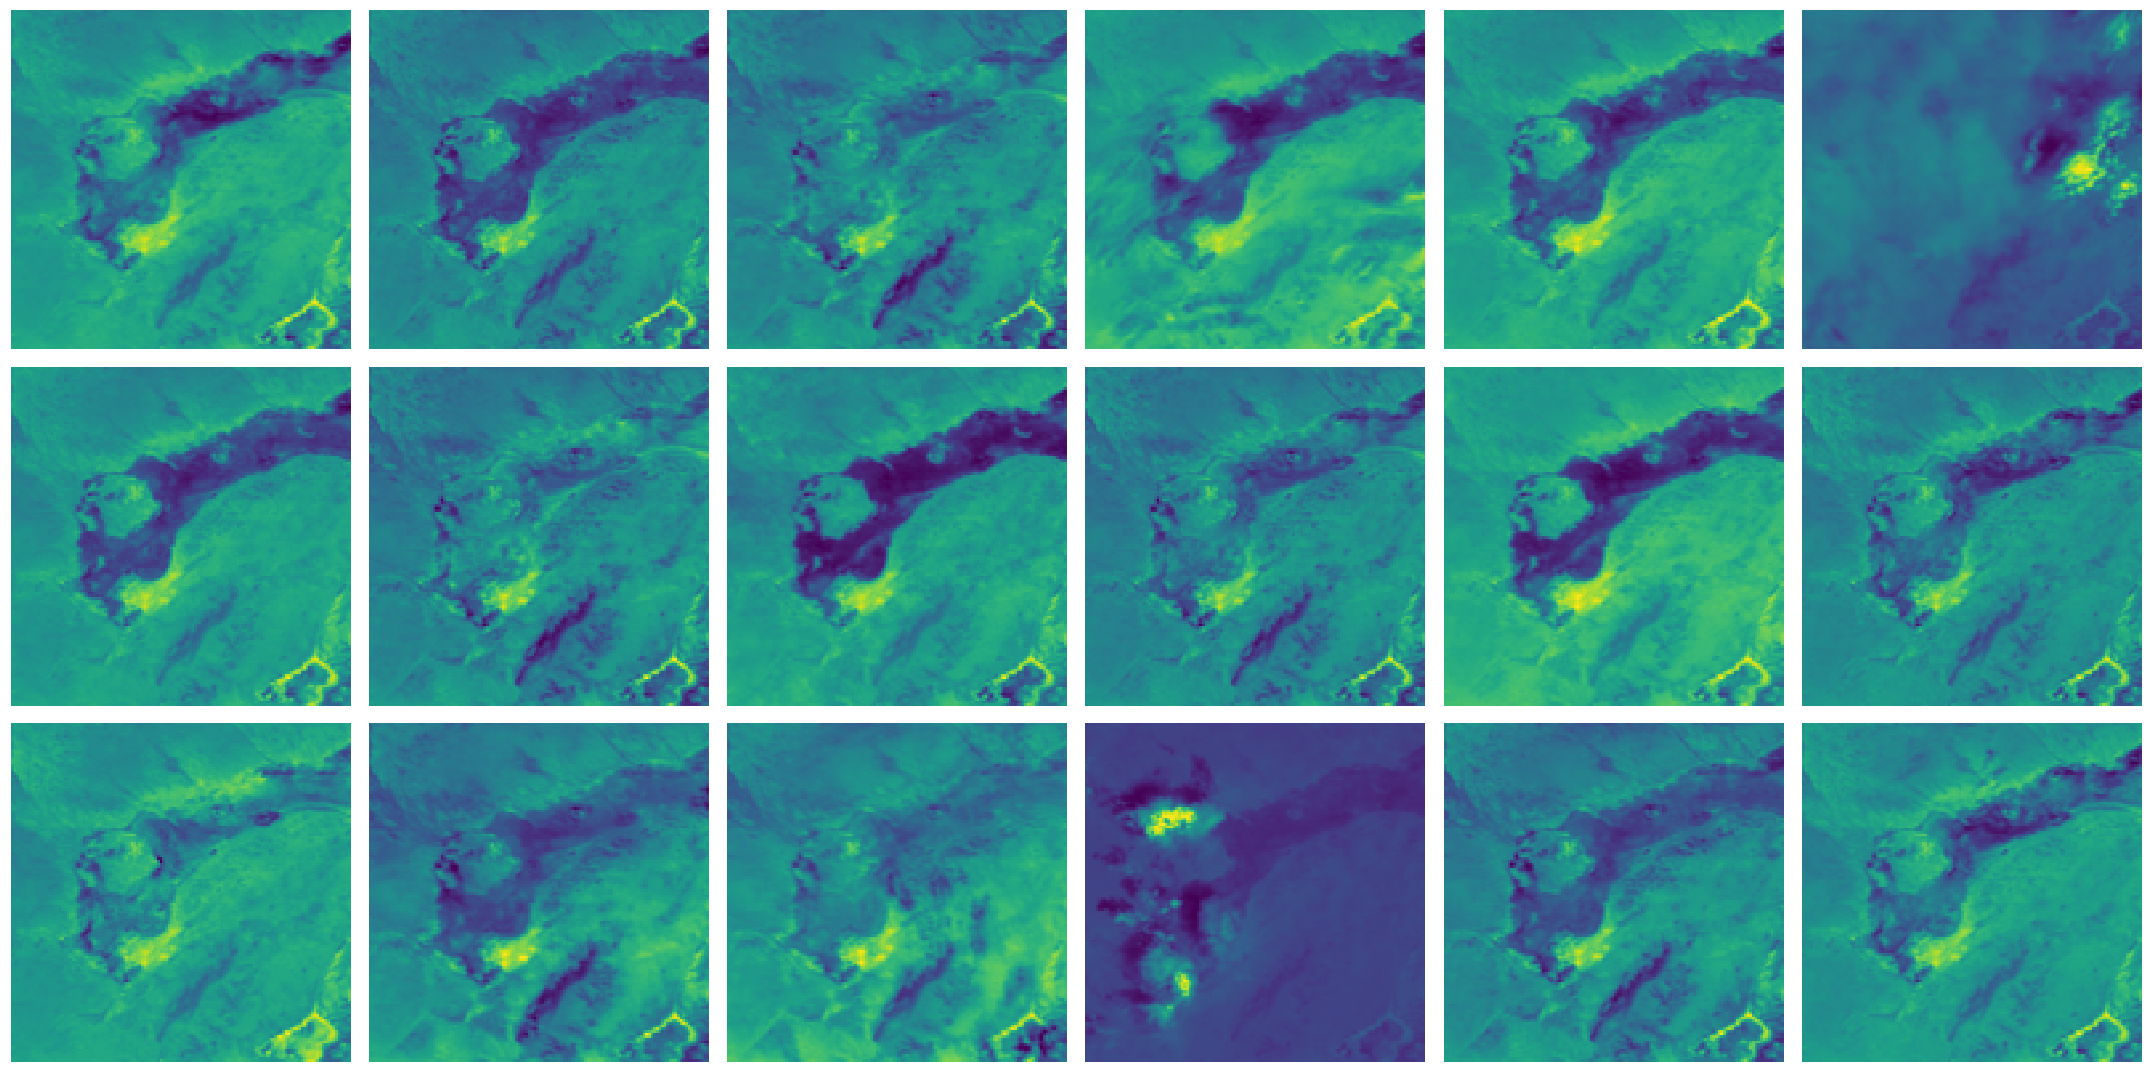

In [13]:
nrows = 3
ncols = int(np.ceil(len(lr) / nrows))

fig, axs = create_panel(ncols, nrows)

for ax, i in zip(axs.flat, lr):
    ax.imshow(i)

Quite a high degree of variability, in a scene that as we'll see below is actually one of the best scored ones (cPSNR: 0.89)!

---

## `compare_images()`

A comparison between two images can be obtained with `compare_images()`. It shows both images side by side, along with a third image depicting the difference between them. This difference is measured as in the competition's scoring function: it's the squared difference between pixel values, after compensating for the bias in brightness. The colormap is scaled so a difference of 0.0 maps to pure white.

Here is the comparison between two of the previous scene's low-resolution images:

In [14]:
a = lr[0]
b = lr[2]

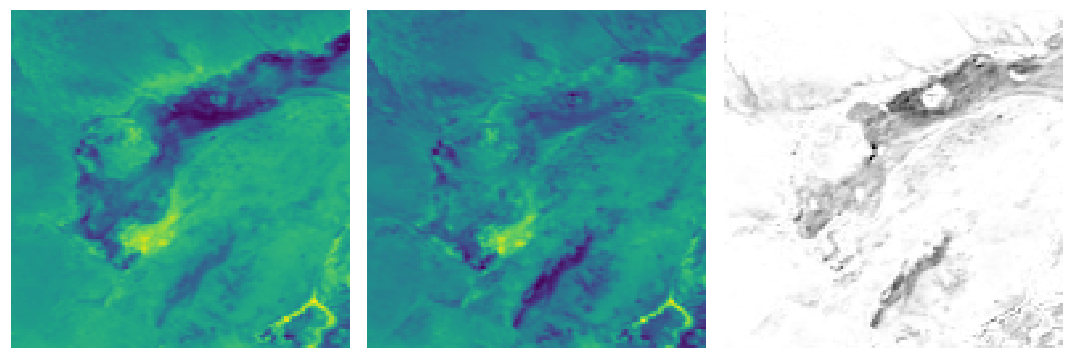

In [15]:
compare_images(a, b);

Should you wish to depict the difference between images in a different way, you can send a third argument with the desired measurement. 

Below we see the absolute difference between images, without compensating for the bias in brightness:

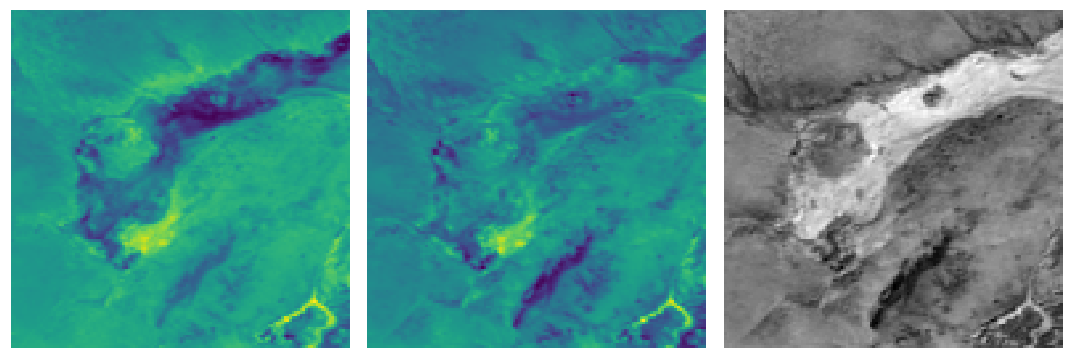

In [16]:
compare_images(a, b, np.abs(a-b));

---

## `compare_to_hr()`

This function helps us see images the way the scoring function sees them.

In [17]:
help(compare_to_hr)

Help on function compare_to_hr in module embiggen.inspect:

compare_to_hr(sr, scene, only_clear=True)
    Compare side-by-side a super-resolved image `sr` of a given `scene` and its
    ground-truth (`hr`, the scene's high-resolution image).
    
    Shows on a third panel the squared difference between both, while
    compensating for the bias in brightness (`b`). Conceals by default
    (`only_clear=True`) the pixels that are obscured in the `hr` image and don't
    therefore interfere in the determination of `sr`'s cPSNR.
    
    Applies the same registration process that is employed by the competition's
    scoring function, which means the displayed images have a total of 6 pixels
    cropped along the edges in each dimension.
    
    The scene's cPSNR value shown on the left panel relates to the (rounded)
    `mean` value on the right panel (if `only_clear=True`) as:
    >>> baseline_cPSNR.loc[scene_id(scene)] / (-10. * np.log10(mean))



Given a super-resolved image `sr` (of 384 by 384 pixels), and the indication of the `scene` to which it corresponds, `compare_to_hr()` plots `sr` next to the scene's high-resolution image. The difference between both that is shown on the right is a full replication of the comparison that takes place in the competition's scoring function: images are aligned, the bias in brightness is compensated for, the squared difference is taken, and obscured pixels in the high-resolution image are ignored (if using the default setting of `only_clear=True`).

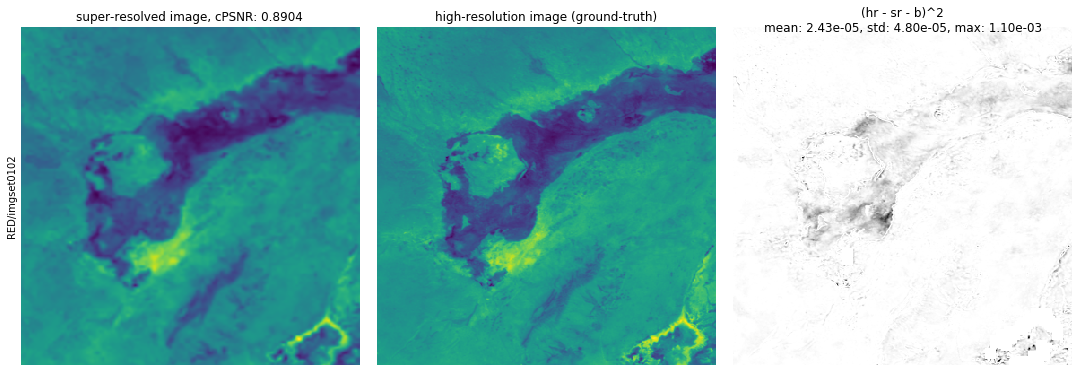

In [18]:
img = bicubic_upscaling(central_tendency(scene))

compare_to_hr(img, scene);

The (rounded) mean squared difference value seen on the third image relates to the image's cPSNR score (seen on the first image) as follows:

In [19]:
baseline_cPSNR.loc[scene_id(scene)][0] / (-10 * np.log10(2.43e-5))

0.8904733557753434

In this scene, the "B" shaped feature near the lower right corner is given in the high-resolution image's status map ("SM.png") as containing several obscured pixels. As a result, those pixels appear in the third image above as pure white, so the visual depiction of the differences won't include pixels that are ignored by the scoring function.

By calling `compare_to_hr()` with a setting of `only_clear=False`, that third image will show the difference at all pixels, regardless of whether or not the scoring function ignores them.

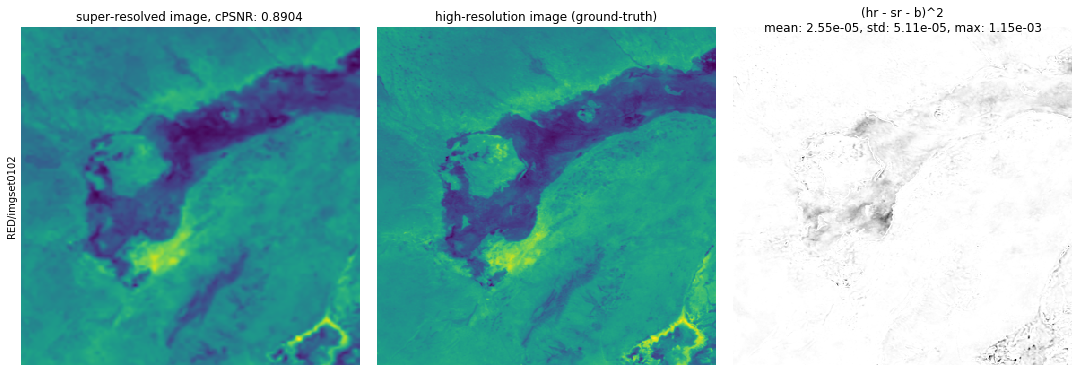

In [21]:
compare_to_hr(img, scene, only_clear=False);

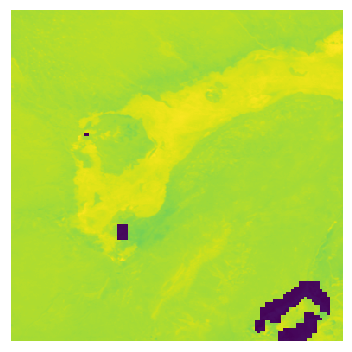

In [20]:
hr, sm = highres_image(scene)
create_panel(1,1)[1].imshow((hr - sm)**2);

----

Here we go back to the super-resolved images generated in the previous section through the "median of all" approach. We identify the worst scored images and call `compare_to_hr()` with some of them, so we can get a better sense for which kind of terrain features degrade the score.

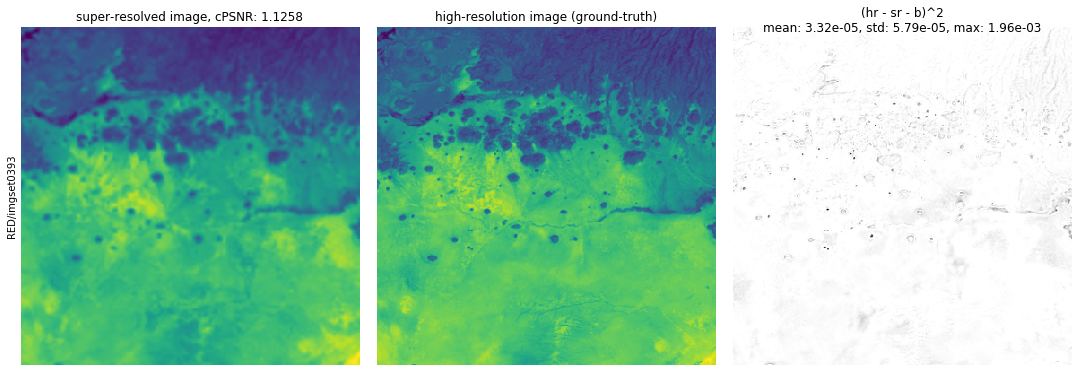

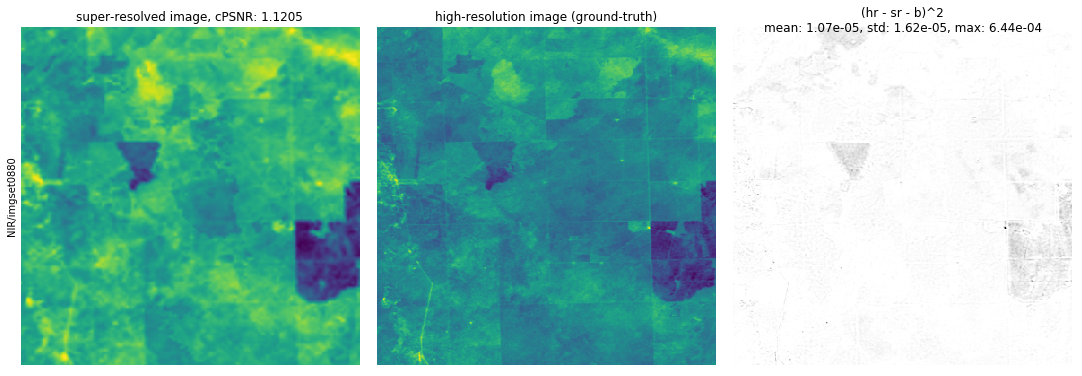

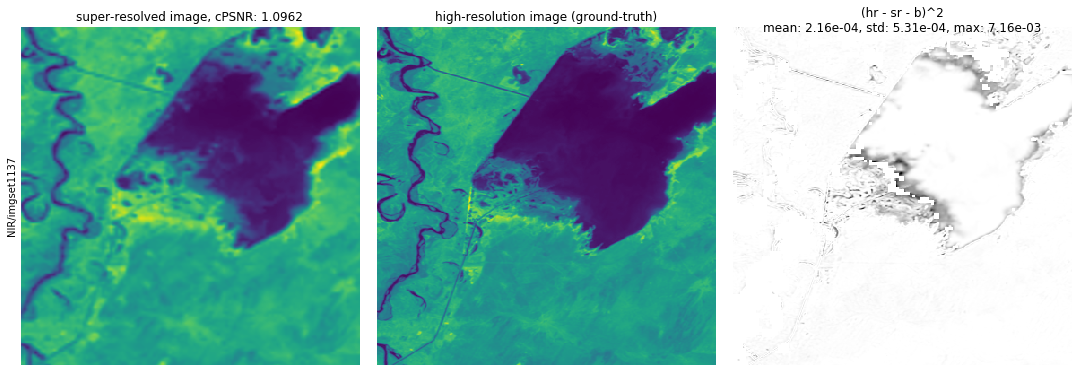

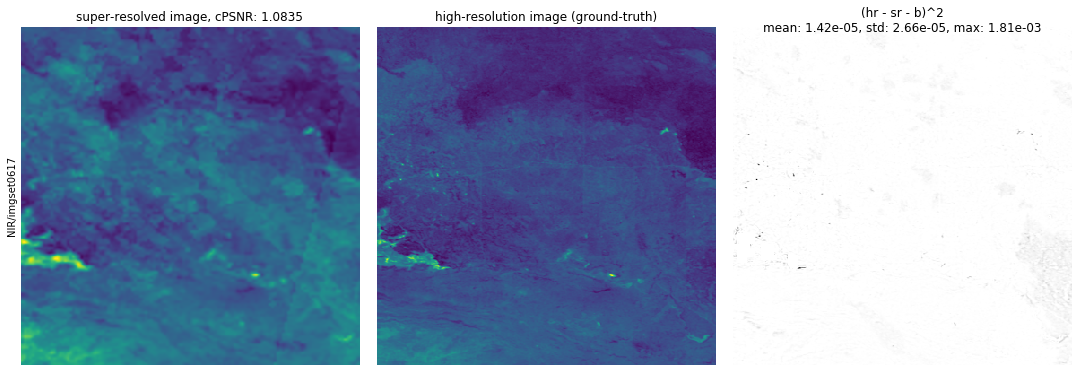

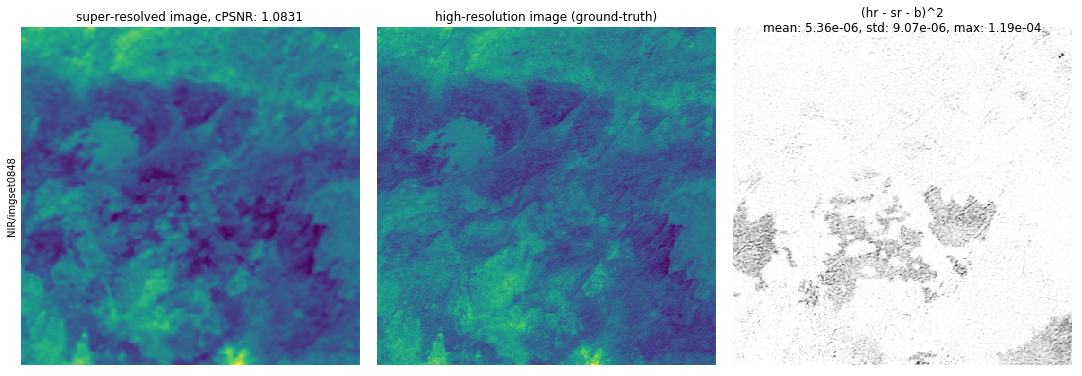

In [22]:
worst = sorted(zip(sc_imgs, score.paths), reverse=True)
sr_imgs = dict(zip(score.paths, sr))

for scn_sc, scn in worst[5:10]:
    compare_to_hr(sr_imgs[scn], scn)

----

----

Generate the Table of Contents

In [23]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')
// https://github.com/kmahelona/ipython_notebook_goodies

<IPython.core.display.Javascript object>

----